In [311]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy import stats

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False)
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()


In [142]:
with open('model_gw_frozen_N2N_SL.json', 'r') as f:
    results_gw_frozen_SL = json.load(f)
    
with open('model_gw_finetune_SL.json', 'r') as f:
    results_gw_finetune_SL = json.load(f)
    
with open('model_VQA_frozen_HCA.json', 'r') as f:
    results_vqa_frozen = json.load(f)

In [143]:
with open('foilGWVQA.train.json', 'r') as f:
    train = json.load(f)
    
with open('foilGWVQA.test.json', 'r') as f:
    test = json.load(f)
    
with open('foilGWVQA.val.json', 'r') as f:
    val = json.load(f)

In [144]:
with open('cocoObject_target.txt', 'r') as f:
    foil_categories = [l.split()[0] for l in f.readlines()]

In [145]:
print(foil_categories)

['airplane', 'apple', 'backpack', 'ball', 'banana', 'bat', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'chair', 'clock', 'couch', 'cow', 'cup', 'dog', 'donut', 'drier', 'elephant', 'fork', 'frisbee', 'giraffe', 'glass', 'glove', 'handbag', 'horse', 'hydrant', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'phone', 'pizza', 'racket', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'suitcase', 'surfboard', 'table', 'tie', 'toaster', 'toilet', 'toothbrush', 'train', 'truck', 'tv', 'umbrella', 'vase', 'zebra']


In [146]:
#for object areas and object counts in images
with open("annotations_trainval/instances_val2017.json") as in_file:
    instances_val = json.load(in_file)

In [147]:
#for object areas and object counts in images
with open("annotations_trainval/instances_train2017.json") as in_file:
    instances_train = json.load(in_file)

In [201]:
instances_train.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [204]:
instances_all = defaultdict(list)
instances_all['categories'] = instances_train['categories']

for i in instances_val['annotations']:
    instances_all['annotations'].append(i)
    
for i in instances_train['annotations']:
    instances_all['annotations'].append(i)

In [205]:
def get_category_lookup(instances_set):
    
    category_lookup = defaultdict(lambda: defaultdict(str))
    
    for cat in instances_all['categories']:
        
        category_lookup[cat['id']] = {'name':cat['name'], 'supercategory':cat['supercategory']}
    
    return category_lookup

In [206]:
category_lookup = get_category_lookup(instances_all)

In [207]:
def get_image_object_instances(instances_set):
    
    instances = defaultdict(set)
    
    for inst in instances_set['annotations']:
        category_name_supcat = category_lookup[inst['category_id']]
        instances[inst['image_id']].add(category_name_supcat['name'])
        
    return instances

In [208]:
print(instances_all['annotations'][0])

{'segmentation': [[510.66, 423.01, 511.72, 420.03, 510.45, 416.0, 510.34, 413.02, 510.77, 410.26, 510.77, 407.5, 510.34, 405.16, 511.51, 402.83, 511.41, 400.49, 510.24, 398.16, 509.39, 397.31, 504.61, 399.22, 502.17, 399.64, 500.89, 401.66, 500.47, 402.08, 499.09, 401.87, 495.79, 401.98, 490.59, 401.77, 488.79, 401.77, 485.39, 398.58, 483.9, 397.31, 481.56, 396.35, 478.48, 395.93, 476.68, 396.03, 475.4, 396.77, 473.92, 398.79, 473.28, 399.96, 473.49, 401.87, 474.56, 403.47, 473.07, 405.59, 473.39, 407.71, 476.68, 409.41, 479.23, 409.73, 481.56, 410.69, 480.4, 411.85, 481.35, 414.93, 479.86, 418.65, 477.32, 420.03, 476.04, 422.58, 479.02, 422.58, 480.29, 423.01, 483.79, 419.93, 486.66, 416.21, 490.06, 415.57, 492.18, 416.85, 491.65, 420.24, 492.82, 422.9, 493.56, 424.39, 496.43, 424.6, 498.02, 423.01, 498.13, 421.31, 497.07, 420.03, 497.07, 415.15, 496.33, 414.51, 501.1, 411.96, 502.06, 411.32, 503.02, 415.04, 503.33, 418.12, 501.1, 420.24, 498.98, 421.63, 500.47, 424.39, 505.03, 423.32

In [210]:
for inst in instances_all['annotations']:
    if inst['image_id'] == 558840:
        print(inst['category_id'],inst['area'])

58 2765.1486500000005
44 3193.2059999999997
44 1600.3732500000003
47 4314.179250000001
1 66127.9536
44 1234.5397500000004
50 466.50930000000074
1 9611.7572
44 1548.8500999999994
67 18689.786450000014
50 564.4570999999984


In [211]:
train_object_instances = get_image_object_instances(instances_all)

In [212]:
train_object_instances[558840]

{'bottle', 'cup', 'dining table', 'hot dog', 'person', 'spoon'}

In [406]:
#method to obtain the foil accuracy, original accuracy and overall accuracy

def get_foil_orig_overall_acc(results):
    
    #foil and original sentence accuracies separately
    
    foil_correct = 0
    orig_correct = 0 
    foil_incorrect = 0
    orig_incorrect = 0
    
    all_foil = 0
    all_orig = 0
    res_size = len(results)
    
    for r in results:
        res_split = r.split('_')
        if res_split[1] == '0':
            all_orig += 1
            
            if results[r]['answer'] == 'ORIG':
                #original sentence & correct answer
                orig_correct += 1
            else:
                orig_incorrect += 1
        
        elif res_split[1] != '0': 
            all_foil += 1            
            if results[r]['answer'] == 'FOIL':
                #foil sentence & correct answer
                foil_correct += 1     
            else:
                foil_incorrect += 1   
            
    print('All foil', all_foil, 'All original', all_orig, 'All', res_size)
    all_sum = orig_correct + foil_correct + orig_incorrect + foil_incorrect
    print('OC',orig_correct, 'FC',foil_correct, 'OI',orig_incorrect, 'FI', foil_incorrect, 'All',all_sum)
    
    pred_info = {'oc': orig_correct, 'fc':foil_correct, 'oi': orig_incorrect, 'fi':foil_incorrect, }
    
    return foil_correct/all_foil, orig_correct/all_orig, (foil_correct + orig_correct)/res_size, pred_info

In [407]:
foil_acc_gw_frozen_SL, orig_acc_gw_frozen_SL, overall_acc_gw_frozen_SL, pred_dict_gw_frozen_SL = get_foil_orig_overall_acc(results_gw_frozen_SL)
print('GW_Frozen_SL', foil_acc_gw_frozen_SL, orig_acc_gw_frozen_SL, overall_acc_gw_frozen_SL)

All foil 5185 All original 5185 All 10370
OC 3793 FC 2207 OI 1392 FI 2978 All 10370
GW_Frozen_SL 0.42565091610414657 0.731533269045323 0.5785920925747348


In [408]:
foil_acc_gw_fine_SL, orig_acc_gw_fine_SL, overall_acc_gw_fine_SL,pred_dict_gw_fine_SL = get_foil_orig_overall_acc(results_gw_finetune_SL)
print('GW_Finetune_SL', foil_acc_gw_fine_SL, orig_acc_gw_fine_SL, overall_acc_gw_fine_SL)

All foil 5185 All original 5185 All 10370
OC 4366 FC 2166 OI 819 FI 3019 All 10370
GW_Finetune_SL 0.4177434908389585 0.8420443587270974 0.629893924783028


In [409]:
foil_acc_vqa_frozen, orig_acc_vqa_frozen, overall_vqa_frozen, pred_dict_vqa_frozen= get_foil_orig_overall_acc(results_vqa_frozen)
print('VQA_FROZEN', foil_acc_vqa_frozen, orig_acc_vqa_frozen, overall_vqa_frozen)

All foil 5185 All original 5185 All 10370
OC 3565 FC 1644 OI 1620 FI 3541 All 10370
VQA_FROZEN 0.3170684667309547 0.6875602700096431 0.502314368370299


In [411]:
def get_precision_recall(pred_dict):

    '''oc = original correct
    fc = foil correct
    oi = original incorrect
    fi = foil incorrect'''
    
    oc = pred_dict['oc']
    fc = pred_dict['fc']
    
    oi = pred_dict['oi']
    fi = pred_dict['fi']
    
    precision_f = fc / (fc + fi)
    precision_o = oc /(oc + oi)
    
    recall_f = fc / (fc + oi)
    recall_o = oc / (oc + fi)

    return precision_f,precision_o, recall_f, recall_o

In [413]:
precision_f,precision_o, recall_f, recall_o = get_precision_recall(pred_dict_gw_frozen_SL)
print('Prec-rec FROZEN GW:', precision_f,precision_o, recall_f, recall_o)

precision_f,precision_o, recall_f, recall_o = get_precision_recall(pred_dict_gw_fine_SL)
print('Prec-rec FINE GW:', precision_f,precision_o, recall_f, recall_o)

precision_f,precision_o, recall_f, recall_o = get_precision_recall(pred_dict_vqa_frozen)
print('Prec-rec FROZEN VQA:', precision_f,precision_o, recall_f, recall_o)

Prec-rec FROZEN GW: 0.42565091610414657 0.731533269045323 0.6132258960822451 0.5601831339536257
Prec-rec FINE GW: 0.4177434908389585 0.8420443587270974 0.7256281407035176 0.591198375084631
Prec-rec FROZEN VQA: 0.3170684667309547 0.6875602700096431 0.5036764705882353 0.5016887137630172


In [216]:
captions_per_changeid = defaultdict()
set2captions = test

#dictionary that takes change_id and returns caption
#from the given set

for t in set2captions['annotations']:
    if 'Original' in t['change_id']:
        id_bits = '0_'+ str(t['id'])
        captions_per_changeid[id_bits] = t['caption']
    else:
        captions_per_changeid[t['change_id']] = t['caption']
        
print(len(captions_per_changeid))

10370


In [217]:
test['annotations'][7]

{'annType': 'vehicle',
 'caption': 'the shiny bicycle is being shown on a display.',
 'change_id': '420932_1',
 'foilWord': 'bicycle',
 'id': 420932,
 'image_id': 251252,
 'presence': 'FOIL-NOTPRESENT',
 'similarity': '0',
 'source': 'COCO_SuperCatergory',
 'targetWord': 'motorcycle',
 'type': 'COCO'}

In [218]:
captions_per_compound_id = defaultdict()
set2captions = test

#dictionary that takes image id and change_id and returns caption
#from the given set

for t in set2captions['annotations']:
    if 'Original' in t['change_id']:
        id_bits = str(t['image_id']) + '_0_'+ str(t['id'])
        captions_per_compound_id[id_bits] = t['caption']
    else:
        id_bits = str(t['image_id']) + '_'+ str(t['change_id'])
        captions_per_compound_id[id_bits] = t['caption']
        
print(len(captions_per_compound_id))

10370


In [219]:
length2captions = defaultdict(list)

#gets a length and returns all the change_ids for captions of the given length

for c in captions_per_compound_id:
    caption = captions_per_compound_id[c]
    caption = tknzr.tokenize(caption)
    length2captions[len(caption)].append(c)    

In [220]:
print(length2captions.keys())
print(len(length2captions.keys()))

dict_keys([12, 9, 10, 13, 11, 22, 14, 19, 16, 18, 8, 15, 17, 7, 24, 20, 23, 21, 25, 29, 31, 26, 28, 41, 27, 30])
26


In [221]:
length2captions[25]

['32677_0_25859',
 '32677_25859_29',
 '310915_0_747060',
 '310915_747060_2',
 '415073_0_512517',
 '415073_512517_5',
 '127170_0_144527',
 '127170_144527_11']

In [274]:
caption_len_distribution = []

for l in length2captions:
    count_list_sents = len(length2captions[l])
    print(l, count_list_sents)
    caption_len_distribution.extend([l]*count_list_sents)

12 1554
9 1484
10 2134
13 1006
11 2066
22 24
14 650
19 44
16 202
18 74
8 424
15 420
17 128
7 40
24 12
20 36
23 10
21 28
25 8
29 2
31 2
26 10
28 4
41 2
27 2
30 4


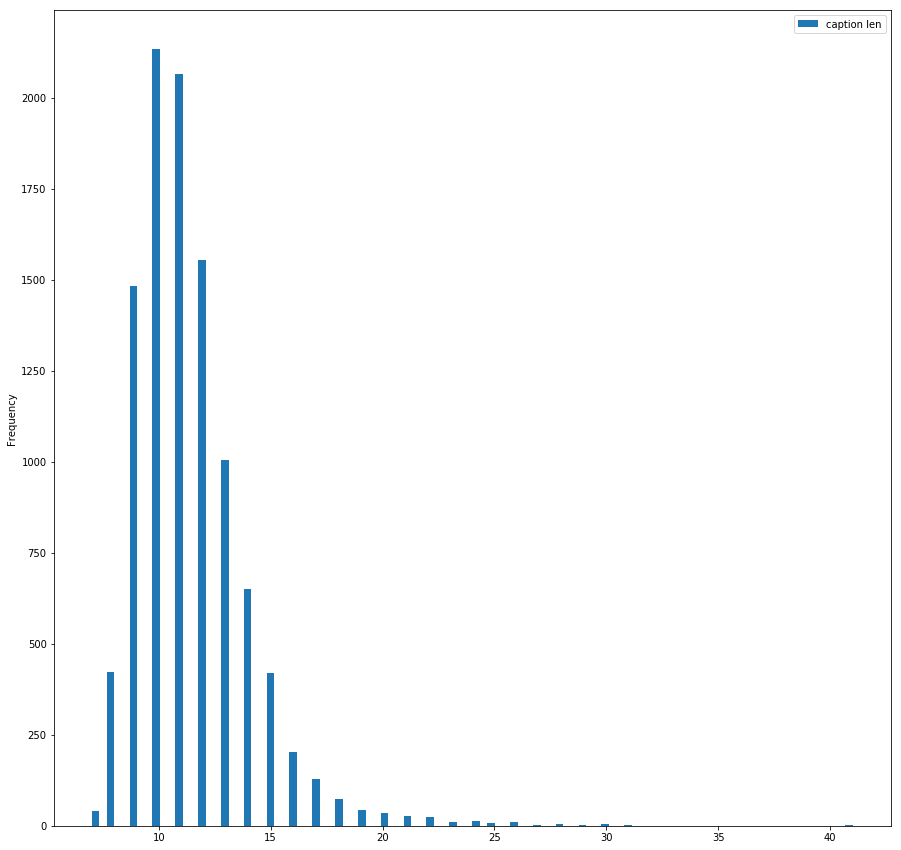

In [276]:
df = pd.DataFrame(caption_len_distribution, columns=['caption len'])
df.plot.hist(figsize=(15,15),bins = 100)
plt.savefig('cap_len.png')
plt.show()

In [320]:
print(stats.normaltest(caption_len_distribution))

NormaltestResult(statistic=4996.5428877496634, pvalue=0.0)


In [223]:
def get_caption_length_acc(results, length2captions):
    
    caption_lengths_accs = defaultdict(list)
    res_size = len(results)
    
    for l in length2captions:
        
        #for all lengths
        count = len(length2captions[l])
            
        foil_correct = 0
        orig_correct = 0 

        all_foil = 0
        all_orig = 0

        for c in length2captions[l]:
            # result of that caption
            
            c_split = c.split('_')
            res = results[c]

            if c_split[1] == '0':
                all_orig += 1
                if res['answer'] == 'ORIG':
                    orig_correct += 1
            else:
                all_foil += 1
                if res['answer'] == 'FOIL':
                    foil_correct += 1
                    
                    
        caption_lengths_accs[l] = [orig_correct/all_orig, foil_correct/all_foil,(orig_correct+foil_correct)/count]
                
    return caption_lengths_accs

In [325]:
caption_lengths_accs = get_caption_length_acc(results_gw_frozen_SL, length2captions)
print('GW_Frozen_SL', caption_lengths_accs)

GW_Frozen_SL defaultdict(<class 'list'>, {12: [0.7258687258687259, 0.40540540540540543, 0.5656370656370656], 9: [0.7641509433962265, 0.4110512129380054, 0.5876010781671159], 10: [0.7488284910965324, 0.42642924086223055, 0.5876288659793815], 13: [0.73558648111332, 0.43339960238568587, 0.584493041749503], 11: [0.7386253630203291, 0.4317521781219748, 0.585188770571152], 22: [0.5833333333333334, 0.6666666666666666, 0.625], 14: [0.7046153846153846, 0.4553846153846154, 0.58], 19: [0.5909090909090909, 0.5454545454545454, 0.5681818181818182], 16: [0.6237623762376238, 0.48514851485148514, 0.5544554455445545], 18: [0.6216216216216216, 0.35135135135135137, 0.4864864864864865], 8: [0.6933962264150944, 0.419811320754717, 0.5566037735849056], 15: [0.719047619047619, 0.40476190476190477, 0.5619047619047619], 17: [0.65625, 0.5, 0.578125], 7: [0.8, 0.4, 0.6], 24: [0.5, 0.5, 0.5], 20: [0.6111111111111112, 0.3333333333333333, 0.4722222222222222], 23: [0.6, 0.8, 0.7], 21: [0.8571428571428571, 0.3571428571

In [295]:
for c in caption_lengths_accs:
    print(caption_lengths_accs[c][2],',',caption_lengths_accs[c][0],',',caption_lengths_accs[c][1])

0.5656370656370656 , 0.7258687258687259 , 0.40540540540540543
0.5876010781671159 , 0.7641509433962265 , 0.4110512129380054
0.5876288659793815 , 0.7488284910965324 , 0.42642924086223055
0.584493041749503 , 0.73558648111332 , 0.43339960238568587
0.585188770571152 , 0.7386253630203291 , 0.4317521781219748
0.625 , 0.5833333333333334 , 0.6666666666666666
0.58 , 0.7046153846153846 , 0.4553846153846154
0.5681818181818182 , 0.5909090909090909 , 0.5454545454545454
0.5544554455445545 , 0.6237623762376238 , 0.48514851485148514
0.4864864864864865 , 0.6216216216216216 , 0.35135135135135137
0.5566037735849056 , 0.6933962264150944 , 0.419811320754717
0.5619047619047619 , 0.719047619047619 , 0.40476190476190477
0.578125 , 0.65625 , 0.5
0.6 , 0.8 , 0.4
0.5 , 0.5 , 0.5
0.4722222222222222 , 0.6111111111111112 , 0.3333333333333333
0.7 , 0.6 , 0.8
0.6071428571428571 , 0.8571428571428571 , 0.35714285714285715
0.625 , 0.5 , 0.75
0.5 , 1.0 , 0.0
0.5 , 0.0 , 1.0
0.5 , 0.6 , 0.4
0.25 , 0.5 , 0.0
0.5 , 1.0 , 0.0

In [326]:

list_obj_counts = list(caption_lengths_accs.keys())
list_obj_accs = []

for c in caption_lengths_accs:
    list_obj_accs.append(caption_lengths_accs[c][2])
    
#correlation between the object counts in the images in the training set vs accuracy
coef, p = pearsonr(list_obj_counts, list_obj_accs)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_counts, list_obj_accs)
print('Spearman\'s r:',r, '\np-value:',p)

Pearson's coefficient: -0.383216194404 
p-value: 0.0533063404615
Spearman's r: -0.474725302901 
p-value: 0.0142647472461


In [226]:
print(list_obj_counts, list_obj_accs)

[12, 9, 10, 13, 11, 22, 14, 19, 16, 18, 8, 15, 17, 7, 24, 20, 23, 21, 25, 29, 31, 26, 28, 41, 27, 30] [0.5656370656370656, 0.5876010781671159, 0.5876288659793815, 0.584493041749503, 0.585188770571152, 0.625, 0.58, 0.5681818181818182, 0.5544554455445545, 0.4864864864864865, 0.5566037735849056, 0.5619047619047619, 0.578125, 0.6, 0.5, 0.4722222222222222, 0.7, 0.6071428571428571, 0.625, 0.5, 0.5, 0.5, 0.25, 0.5, 0.0, 0.5]


In [330]:
caption_lengths_accs = get_caption_length_acc(results_gw_finetune_SL, length2captions)
print('GW_Fine_SL', caption_lengths_accs)


list_obj_counts = list(caption_lengths_accs.keys())
list_obj_accs = []

for c in caption_lengths_accs:
    list_obj_accs.append(caption_lengths_accs[c][2])
    
#correlation between the object counts in the images in the training set vs accuracy
coef, p = pearsonr(list_obj_counts, list_obj_accs)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_counts, list_obj_accs)
print('Spearman\'s r:',r, '\np-value:',p)


GW_Fine_SL defaultdict(<class 'list'>, {12: [0.8738738738738738, 0.4375804375804376, 0.6557271557271557], 9: [0.8355795148247979, 0.4110512129380054, 0.6233153638814016], 10: [0.8397375820056232, 0.40393626991565135, 0.6218369259606373], 13: [0.827037773359841, 0.3817097415506958, 0.6043737574552683], 11: [0.846079380445305, 0.4181994191674734, 0.6321393998063891], 22: [0.75, 0.6666666666666666, 0.7083333333333334], 14: [0.8584615384615385, 0.44, 0.6492307692307693], 19: [0.9545454545454546, 0.5, 0.7272727272727273], 16: [0.801980198019802, 0.32673267326732675, 0.5643564356435643], 18: [0.8378378378378378, 0.40540540540540543, 0.6216216216216216], 8: [0.8301886792452831, 0.5047169811320755, 0.6674528301886793], 15: [0.8095238095238095, 0.3904761904761905, 0.6], 17: [0.859375, 0.46875, 0.6640625], 7: [0.8, 0.3, 0.55], 24: [0.8333333333333334, 0.5, 0.6666666666666666], 20: [0.7777777777777778, 0.4444444444444444, 0.6111111111111112], 23: [0.8, 0.6, 0.7], 21: [0.7857142857142857, 0.428571

In [329]:
print(list_obj_counts, list_obj_accs)

[12, 9, 10, 13, 11, 22, 14, 19, 16, 18, 8, 15, 17, 7, 24, 20, 23, 21, 25, 29, 31, 26, 28, 41, 27, 30] [0.6557271557271557, 0.6233153638814016, 0.6218369259606373, 0.6043737574552683, 0.6321393998063891, 0.7083333333333334, 0.6492307692307693, 0.7272727272727273, 0.5643564356435643, 0.6216216216216216, 0.6674528301886793, 0.6, 0.6640625, 0.55, 0.6666666666666666, 0.6111111111111112, 0.7, 0.6071428571428571, 0.625, 0.5, 0.5, 0.7, 0.5, 0.5, 0.5, 0.5]


In [292]:
sorted_pos = sorted(caption_lengths_accs.keys())

for s in sorted_pos:
    print(s, caption_lengths_accs[s])

7 [0.8, 0.3, 0.55]
8 [0.8301886792452831, 0.5047169811320755, 0.6674528301886793]
9 [0.8355795148247979, 0.4110512129380054, 0.6233153638814016]
10 [0.8397375820056232, 0.40393626991565135, 0.6218369259606373]
11 [0.846079380445305, 0.4181994191674734, 0.6321393998063891]
12 [0.8738738738738738, 0.4375804375804376, 0.6557271557271557]
13 [0.827037773359841, 0.3817097415506958, 0.6043737574552683]
14 [0.8584615384615385, 0.44, 0.6492307692307693]
15 [0.8095238095238095, 0.3904761904761905, 0.6]
16 [0.801980198019802, 0.32673267326732675, 0.5643564356435643]
17 [0.859375, 0.46875, 0.6640625]
18 [0.8378378378378378, 0.40540540540540543, 0.6216216216216216]
19 [0.9545454545454546, 0.5, 0.7272727272727273]
20 [0.7777777777777778, 0.4444444444444444, 0.6111111111111112]
21 [0.7857142857142857, 0.42857142857142855, 0.6071428571428571]
22 [0.75, 0.6666666666666666, 0.7083333333333334]
23 [0.8, 0.6, 0.7]
24 [0.8333333333333334, 0.5, 0.6666666666666666]
25 [0.75, 0.5, 0.625]
26 [0.6, 0.8, 0.7]
2

In [293]:
for c in caption_lengths_accs:
    print(caption_lengths_accs[c][2],',',caption_lengths_accs[c][0],',',caption_lengths_accs[c][1])

0.6557271557271557 , 0.8738738738738738 , 0.4375804375804376
0.6233153638814016 , 0.8355795148247979 , 0.4110512129380054
0.6218369259606373 , 0.8397375820056232 , 0.40393626991565135
0.6043737574552683 , 0.827037773359841 , 0.3817097415506958
0.6321393998063891 , 0.846079380445305 , 0.4181994191674734
0.7083333333333334 , 0.75 , 0.6666666666666666
0.6492307692307693 , 0.8584615384615385 , 0.44
0.7272727272727273 , 0.9545454545454546 , 0.5
0.5643564356435643 , 0.801980198019802 , 0.32673267326732675
0.6216216216216216 , 0.8378378378378378 , 0.40540540540540543
0.6674528301886793 , 0.8301886792452831 , 0.5047169811320755
0.6 , 0.8095238095238095 , 0.3904761904761905
0.6640625 , 0.859375 , 0.46875
0.55 , 0.8 , 0.3
0.6666666666666666 , 0.8333333333333334 , 0.5
0.6111111111111112 , 0.7777777777777778 , 0.4444444444444444
0.7 , 0.8 , 0.6
0.6071428571428571 , 0.7857142857142857 , 0.42857142857142855
0.625 , 0.75 , 0.5
0.5 , 1.0 , 0.0
0.5 , 0.0 , 1.0
0.7 , 0.6 , 0.8
0.5 , 0.5 , 0.5
0.5 , 0.0 

In [394]:
caption_lengths_accs = get_caption_length_acc(results_vqa_frozen, length2captions)
print('VQA_FROZEN', caption_lengths_accs)

list_obj_counts = list(caption_lengths_accs.keys())
list_obj_accs = []

for c in caption_lengths_accs:
    list_obj_accs.append(caption_lengths_accs[c][2])
    
#correlation between the object counts in the images in the training set vs accuracy
coef, p = pearsonr(list_obj_counts, list_obj_accs)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_counts, list_obj_accs)
print('Spearman\'s r:',r, '\np-value:',p)


VQA_FROZEN defaultdict(<class 'list'>, {12: [0.6988416988416989, 0.3088803088803089, 0.5038610038610039], 9: [0.6738544474393531, 0.32345013477088946, 0.49865229110512127], 10: [0.662605435801312, 0.33270852858481725, 0.49765698219306465], 13: [0.6878727634194831, 0.33001988071570576, 0.5089463220675944], 11: [0.7047434656340755, 0.3010648596321394, 0.5029041626331074], 22: [0.4166666666666667, 0.6666666666666666, 0.5416666666666666], 14: [0.7169230769230769, 0.3230769230769231, 0.52], 19: [0.8636363636363636, 0.13636363636363635, 0.5], 16: [0.7425742574257426, 0.32673267326732675, 0.5346534653465347], 18: [0.5675675675675675, 0.35135135135135137, 0.4594594594594595], 8: [0.7358490566037735, 0.25, 0.49292452830188677], 15: [0.6904761904761905, 0.3142857142857143, 0.5023809523809524], 17: [0.5625, 0.375, 0.46875], 7: [0.55, 0.25, 0.4], 24: [1.0, 0.0, 0.5], 20: [0.4444444444444444, 0.5, 0.4722222222222222], 23: [0.4, 0.4, 0.4], 21: [0.7857142857142857, 0.21428571428571427, 0.5], 25: [0.5

In [313]:
foil_positions_per_caption = defaultdict(list)
set2captions = test

#dictionary that takes foil position and returns image id and change_id
#from the given set ONLY FOR FOIL SENTENCES
foil_caption_rel_pos = defaultdict(float)
foil_caption_abs_pos = defaultdict(float)

for t in set2captions['annotations']:
    if 'Original' in t['change_id']:
        pass
    else:
        caption_split = tknzr.tokenize(t['caption'])
        target = t['foilWord']
        
        abs_position = -1
        rel_position = -1
        
        orig_caption_split = tknzr.tokenize(captions_per_changeid['0_' + str(t['change_id'].split('_')[0])])
            
        for i in range(len(caption_split)):
            if caption_split[i] != orig_caption_split[i]:
                abs_position = i+1
                rel_position = (i+1)/len(caption_split)
              
        id_bits = str(t['image_id']) + '_'+ str(t['change_id'])
        foil_positions_per_caption[abs_position].append(id_bits)
        foil_caption_rel_pos[id_bits] = rel_position
        foil_caption_abs_pos[id_bits] = abs_position
        
print(len(foil_positions_per_caption)) #TODO must be equal to the number of foil sentences

24


In [297]:
print(foil_positions_per_caption.keys())

dict_keys([11, 8, 10, 3, 2, 6, 12, 5, 9, 1, 18, 7, 15, 4, 13, 16, 14, 17, 21, 22, 35, 19, 23, 20])


In [298]:
foil_caption_rel_pos

defaultdict(float,
            {'522418_681330_7': 0.9166666666666666,
             '522418_686718_7': 0.8888888888888888,
             '522418_693159_7': 1.0,
             '251252_420932_1': 0.3,
             '251252_423539_1': 0.3333333333333333,
             '251252_424295_1': 0.16666666666666666,
             '251252_424592_2': 0.2,
             '268556_226907_1': 0.6,
             '268556_228905_8': 0.9230769230769231,
             '268556_239120_1': 0.4166666666666667,
             '199951_36178_2': 0.2222222222222222,
             '527040_776777_3': 0.9,
             '560623_241451_4': 0.2,
             '242139_168083_2': 0.2222222222222222,
             '29913_394782_2': 0.16666666666666666,
             '460347_77750_3': 0.3,
             '78522_667429_5': 0.2,
             '78522_674266_5': 0.3,
             '78522_675862_5': 0.1,
             '129942_232471_5': 0.2727272727272727,
             '129942_241663_1': 0.4166666666666667,
             '437609_763972_6': 0.6,
      

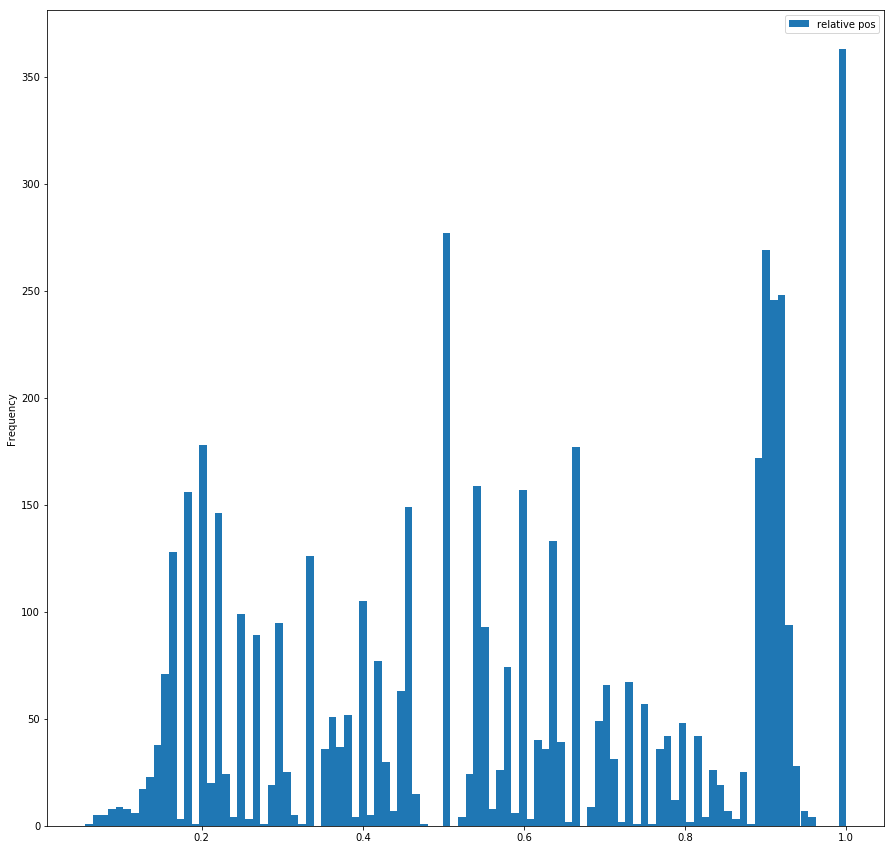

In [299]:
rel_pos_distribution = [foil_caption_rel_pos[k] for k in foil_caption_rel_pos]
df = pd.DataFrame(rel_pos_distribution, columns=['relative pos'])
df.plot.hist(figsize=(15,15),bins = 100)
plt.savefig('rel_pos.png')
plt.show()

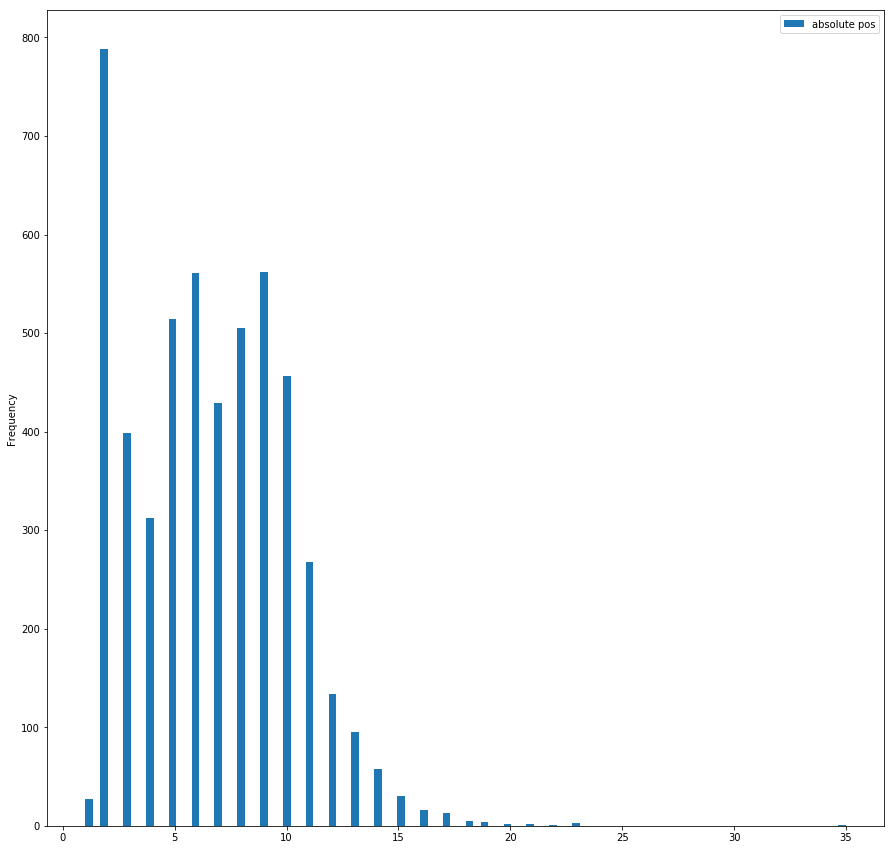

In [317]:
abs_pos_distribution = [foil_caption_abs_pos[k] for k in foil_caption_abs_pos]
df = pd.DataFrame(abs_pos_distribution, columns=['absolute pos'])
df.plot.hist(figsize=(15,15),bins = 100)
plt.savefig('abs_pos.png')
plt.show()

In [318]:
print(stats.normaltest(abs_pos_distribution))

NormaltestResult(statistic=298.32270109964674, pvalue=1.6597724170211482e-65)


In [319]:
print(stats.normaltest(rel_pos_distribution))

NormaltestResult(statistic=20094.32526862562, pvalue=0.0)


In [300]:
def get_position_acc(results, foil_positions_per_caption):
    
    absolute_acc = defaultdict(float)
    relative_acc = defaultdict(float) 
    
    for p in foil_positions_per_caption:
        accuracy_sum = 0
        count = len(foil_positions_per_caption[p])
        
        for c in foil_positions_per_caption[p]:
            # result of that caption
            c_split = c.split('_')
            res = results[c]

            if c_split[1] != '0' and res['answer'] == 'FOIL':
                    #foil sentence & correct answer
                    accuracy_sum += 1
                    
        absolute_acc[p] = accuracy_sum/count
        
        #TODO relative pos
    return absolute_acc, relative_acc

In [307]:
absolute_acc, relative_acc = get_position_acc(results_gw_frozen_SL, foil_positions_per_caption)
print('GW_Frozen_SL', absolute_acc, relative_acc)

sorted_pos = sorted(absolute_acc.keys())

for s in sorted_pos:
    print(s,',', absolute_acc[s])

GW_Frozen_SL defaultdict(<class 'float'>, {11: 0.44029850746268656, 8: 0.4099009900990099, 10: 0.4473684210526316, 3: 0.43609022556390975, 2: 0.4010152284263959, 6: 0.40463458110516937, 12: 0.39552238805970147, 5: 0.46303501945525294, 9: 0.40213523131672596, 1: 0.2962962962962963, 18: 0.4, 7: 0.4382284382284382, 15: 0.5666666666666667, 4: 0.4519230769230769, 13: 0.47368421052631576, 16: 0.6875, 14: 0.41379310344827586, 17: 0.3076923076923077, 21: 0.5, 22: 0.0, 35: 0.0, 19: 0.5, 23: 0.3333333333333333, 20: 0.0}) defaultdict(<class 'float'>, {})
1 , 0.2962962962962963
2 , 0.4010152284263959
3 , 0.43609022556390975
4 , 0.4519230769230769
5 , 0.46303501945525294
6 , 0.40463458110516937
7 , 0.4382284382284382
8 , 0.4099009900990099
9 , 0.40213523131672596
10 , 0.4473684210526316
11 , 0.44029850746268656
12 , 0.39552238805970147
13 , 0.47368421052631576
14 , 0.41379310344827586
15 , 0.5666666666666667
16 , 0.6875
17 , 0.3076923076923077
18 , 0.4
19 , 0.5
20 , 0.0
21 , 0.5
22 , 0.0
23 , 0.333

In [321]:
list_obj_counts = list(absolute_acc.keys())
list_obj_accs = []

for c in absolute_acc:
    list_obj_accs.append(absolute_acc[c])
    
#correlation between the object counts in the images in the training set vs accuracy
coef, p = pearsonr(list_obj_counts, list_obj_accs)
print('Pearson\'s coefficient:',coef, '\np-value:', p)
r, p = spearmanr(list_obj_counts, list_obj_accs)
print('Spearman\'s r:',r, '\np-value:',p)

Pearson's coefficient: -0.456098765273 
p-value: 0.025085230506
Spearman's r: -0.175843412047 
p-value: 0.411134393653


In [235]:
#todo regression model combining rel and abs
#todo rel distribution

In [324]:
absolute_acc, relative_acc = get_position_acc(results_gw_finetune_SL, foil_positions_per_caption)
print('GW_Fine_SL', absolute_acc, relative_acc)

sorted_pos = sorted(absolute_acc.keys())

for s in sorted_pos:
    print(s,',', absolute_acc[s])
    

list_obj_counts = list(absolute_acc.keys())
list_obj_accs = []

for c in absolute_acc:
    list_obj_accs.append(absolute_acc[c])
    
#correlation between the object counts in the images in the training set vs accuracy
coef, p = pearsonr(list_obj_counts, list_obj_accs)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_counts, list_obj_accs)
print('Spearman\'s r:',r, '\np-value:',p)

GW_Fine_SL defaultdict(<class 'float'>, {11: 0.43656716417910446, 8: 0.4613861386138614, 10: 0.4144736842105263, 3: 0.41102756892230574, 2: 0.3604060913705584, 6: 0.43672014260249553, 12: 0.44029850746268656, 5: 0.48249027237354086, 9: 0.40213523131672596, 1: 0.2962962962962963, 18: 0.4, 7: 0.42657342657342656, 15: 0.5666666666666667, 4: 0.3333333333333333, 13: 0.4105263157894737, 16: 0.6875, 14: 0.3793103448275862, 17: 0.38461538461538464, 21: 1.0, 22: 0.0, 35: 1.0, 19: 1.0, 23: 0.6666666666666666, 20: 0.5}) defaultdict(<class 'float'>, {})
1 , 0.2962962962962963
2 , 0.3604060913705584
3 , 0.41102756892230574
4 , 0.3333333333333333
5 , 0.48249027237354086
6 , 0.43672014260249553
7 , 0.42657342657342656
8 , 0.4613861386138614
9 , 0.40213523131672596
10 , 0.4144736842105263
11 , 0.43656716417910446
12 , 0.44029850746268656
13 , 0.4105263157894737
14 , 0.3793103448275862
15 , 0.5666666666666667
16 , 0.6875
17 , 0.38461538461538464
18 , 0.4
19 , 1.0
20 , 0.5
21 , 1.0
22 , 0.0
23 , 0.66666

In [395]:
absolute_acc, relative_acc = get_position_acc(results_vqa_frozen, foil_positions_per_caption)
print('VQA_FROZEN', absolute_acc, relative_acc)

sorted_pos = sorted(absolute_acc.keys())

for s in sorted_pos:
    print(s,',', absolute_acc[s])
    

list_obj_counts = list(absolute_acc.keys())
list_obj_accs = []

for c in absolute_acc:
    list_obj_accs.append(absolute_acc[c])
    
#correlation between the object counts in the images in the training set vs accuracy
coef, p = pearsonr(list_obj_counts, list_obj_accs)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_counts, list_obj_accs)
print('Spearman\'s r:',r, '\np-value:',p)

VQA_FROZEN defaultdict(<class 'float'>, {11: 0.30223880597014924, 8: 0.3207920792079208, 10: 0.31140350877192985, 3: 0.3082706766917293, 2: 0.3096446700507614, 6: 0.3333333333333333, 12: 0.3358208955223881, 5: 0.32684824902723736, 9: 0.3167259786476868, 1: 0.2222222222222222, 18: 0.4, 7: 0.30303030303030304, 15: 0.4, 4: 0.3333333333333333, 13: 0.28421052631578947, 16: 0.3125, 14: 0.3103448275862069, 17: 0.38461538461538464, 21: 0.5, 22: 1.0, 35: 0.0, 19: 0.25, 23: 0.3333333333333333, 20: 0.5}) defaultdict(<class 'float'>, {})
1 , 0.2222222222222222
2 , 0.3096446700507614
3 , 0.3082706766917293
4 , 0.3333333333333333
5 , 0.32684824902723736
6 , 0.3333333333333333
7 , 0.30303030303030304
8 , 0.3207920792079208
9 , 0.3167259786476868
10 , 0.31140350877192985
11 , 0.30223880597014924
12 , 0.3358208955223881
13 , 0.28421052631578947
14 , 0.3103448275862069
15 , 0.4
16 , 0.3125
17 , 0.38461538461538464
18 , 0.4
19 , 0.25
20 , 0.5
21 , 0.5
22 , 1.0
23 , 0.3333333333333333
35 , 0.0
Pearson's c

In [238]:
supercategory_captions = defaultdict(list)
set2captions = test

#dictionary that takes supercategory and returns image id and change_id
#from the given set ONLY FOR FOIL SENTENCES

for t in set2captions['annotations']:
    if 'Original' in t['change_id']:
        pass
    else:
        sup_cat = t['annType']
        id_bits = str(t['image_id']) + '_'+ str(t['change_id'])
        supercategory_captions[sup_cat].append(id_bits)
        
print(len(supercategory_captions))

11


In [239]:
supercategory_captions.keys()

dict_keys(['food', 'vehicle', 'furniture', 'kitchen', 'animal', 'accessory', 'sports', 'electronic', 'indoor', 'appliance', 'outdoor'])

In [240]:
def get_supercat_acc(results, supercategory_captions):
    
    supercat_acc = defaultdict(float)
    
    for s in supercategory_captions:
        accuracy_sum = 0
        count = len(supercategory_captions[s])
#         if count == 0:
#             print(supercategory_captions[s])

        for c in supercategory_captions[s]:
            # result of that caption
            c_split = c.split('_')
            res = results[c]

            if c_split[1] != '0' and res['answer'] == 'FOIL':
                    #foil sentence & correct answer
                    accuracy_sum += 1
                    
        supercat_acc[s] = accuracy_sum/count
        
    return supercat_acc

In [241]:
supercat_acc = get_supercat_acc(results_gw_frozen_SL, supercategory_captions)
print('GW_Frozen_SL', supercat_acc)

GW_Frozen_SL defaultdict(<class 'float'>, {'food': 0.27543035993740217, 'vehicle': 0.41878453038674035, 'furniture': 0.5, 'kitchen': 0.5214285714285715, 'animal': 0.4211123723041998, 'accessory': 0.7051282051282052, 'sports': 0.38963963963963966, 'electronic': 0.4281842818428184, 'indoor': 0.48226950354609927, 'appliance': 0.42028985507246375, 'outdoor': 0.6})


In [242]:
supercat_acc

defaultdict(float,
            {'accessory': 0.7051282051282052,
             'animal': 0.4211123723041998,
             'appliance': 0.42028985507246375,
             'electronic': 0.4281842818428184,
             'food': 0.27543035993740217,
             'furniture': 0.5,
             'indoor': 0.48226950354609927,
             'kitchen': 0.5214285714285715,
             'outdoor': 0.6,
             'sports': 0.38963963963963966,
             'vehicle': 0.41878453038674035})

In [243]:
supercat_acc = get_supercat_acc(results_gw_finetune_SL, supercategory_captions)
print('GW_Fine_SL', supercat_acc)
supercat_acc

GW_Fine_SL defaultdict(<class 'float'>, {'food': 0.29107981220657275, 'vehicle': 0.39337016574585637, 'furniture': 0.5179948586118251, 'kitchen': 0.5142857142857142, 'animal': 0.4188422247446084, 'accessory': 0.6602564102564102, 'sports': 0.40202702702702703, 'electronic': 0.36314363143631434, 'indoor': 0.46099290780141844, 'appliance': 0.34782608695652173, 'outdoor': 0.1})


defaultdict(float,
            {'accessory': 0.6602564102564102,
             'animal': 0.4188422247446084,
             'appliance': 0.34782608695652173,
             'electronic': 0.36314363143631434,
             'food': 0.29107981220657275,
             'furniture': 0.5179948586118251,
             'indoor': 0.46099290780141844,
             'kitchen': 0.5142857142857142,
             'outdoor': 0.1,
             'sports': 0.40202702702702703,
             'vehicle': 0.39337016574585637})

In [393]:
supercat_acc = get_supercat_acc(results_vqa_frozen, supercategory_captions)
print('VQA_frozen_SL', supercat_acc)
supercat_acc

VQA_frozen_SL defaultdict(<class 'float'>, {'food': 0.35524256651017216, 'vehicle': 0.22983425414364642, 'furniture': 0.35475578406169667, 'kitchen': 0.29642857142857143, 'animal': 0.38251986379114644, 'accessory': 0.3141025641025641, 'sports': 0.26126126126126126, 'electronic': 0.4092140921409214, 'indoor': 0.23404255319148937, 'appliance': 0.32608695652173914, 'outdoor': 0.3})


defaultdict(float,
            {'accessory': 0.3141025641025641,
             'animal': 0.38251986379114644,
             'appliance': 0.32608695652173914,
             'electronic': 0.4092140921409214,
             'food': 0.35524256651017216,
             'furniture': 0.35475578406169667,
             'indoor': 0.23404255319148937,
             'kitchen': 0.29642857142857143,
             'outdoor': 0.3,
             'sports': 0.26126126126126126,
             'vehicle': 0.22983425414364642})

In [331]:
def get_obj_frequency(train, obj_categories):
    
    obj_frequencies = defaultdict(int)
    
    for c in obj_categories:
        for t in train['annotations']:
            caption_split = t['caption'].split()
            
            for w in caption_split:
                if c == w:
                    #exactly the same word as the target
                    obj_frequencies[c] += 1
                elif c in w:
                    #contains target but not the same word
                    #tokenize for .
                    #lemmatize for plurals
                    
                    tokenized_w = tknzr.tokenize(w)
                    
                    for tw in tokenized_w:
                        if c == wordnet_lemmatizer.lemmatize(tw):
                            obj_frequencies[c] += 1
                            #print (c,tokenized_w, wordnet_lemmatizer.lemmatize(tw))
                    
    return obj_frequencies

In [389]:
obj_frequencies = get_obj_frequency(train, foil_categories)

for obj in obj_frequencies:
    print(obj, ',', obj_frequencies[obj])

airplane , 212
apple , 265
backpack , 188
ball , 1423
banana , 598
bat , 1846
bear , 929
bed , 1312
bench , 498
bicycle , 339
bird , 528
boat , 779
book , 464
bottle , 474
bowl , 979
broccoli , 457
bus , 2412
cake , 1634
car , 1728
carrot , 273
cat , 2728
chair , 1840
clock , 532
couch , 2100
cow , 1164
cup , 785
dog , 2175
donut , 953
elephant , 1092
fork , 410
frisbee , 1079
giraffe , 387
glass , 926
glove , 585
handbag , 7
horse , 958
hydrant , 73
keyboard , 1010
kite , 1369
knife , 279
laptop , 1583
microwave , 405
motorcycle , 959
mouse , 452
orange , 594
oven , 401
phone , 827
pizza , 1309
racket , 544
refrigerator , 419
remote , 741
sandwich , 789
scissors , 119
sheep , 943
sink , 602
skateboard , 1175
skis , 718
snowboard , 685
spoon , 176
suitcase , 617
surfboard , 463
table , 3288
tie , 334
toaster , 26
toilet , 338
toothbrush , 112
train , 2170
truck , 1973
tv , 242
umbrella , 772
vase , 803
zebra , 627


In [390]:
len(obj_frequencies)

72

In [363]:
target_obj_per_caption = defaultdict(str)
set2captions = test
obj_set = set()

#dictionary that takes compound image id and change_id, returns target object
#from the given set ONLY FOR FOIL SENTENCES

for t in set2captions['annotations']:
    if 'Original' in t['change_id']:
        pass
    else:
        target = t['foilWord']
        obj_set.add(target)
        id_bits = str(t['image_id']) + '_'+ str(t['change_id'])
        
        target_obj_per_caption[id_bits] = target
        
print(target_obj_per_caption)

defaultdict(<class 'str'>, {'522418_681330_7': 'pizza', '522418_686718_7': 'pizza', '522418_693159_7': 'pizza', '251252_420932_1': 'bicycle', '251252_423539_1': 'bicycle', '251252_424295_1': 'bicycle', '251252_424592_2': 'car', '268556_226907_1': 'bicycle', '268556_228905_8': 'bicycle', '268556_239120_1': 'bicycle', '199951_36178_2': 'car', '527040_776777_3': 'bed', '560623_241451_4': 'airplane', '242139_168083_2': 'cup', '29913_394782_2': 'motorcycle', '460347_77750_3': 'motorcycle', '78522_667429_5': 'cow', '78522_674266_5': 'cow', '78522_675862_5': 'cow', '129942_232471_5': 'carrot', '129942_241663_1': 'cat', '437609_763972_6': 'elephant', '437609_767074_6': 'elephant', '54088_630152_2': 'car', '54088_636638_8': 'bicycle', '54088_637805_3': 'motorcycle', '54088_638435_5': 'carrot', '383406_119806_6': 'bottle', '171062_69844_12': 'bed', '171062_70327_10': 'chair', '171062_72010_10': 'chair', '171062_78145_12': 'bed', '171062_85114_2': 'dog', '412914_794793_7': 'truck', '233771_240468

In [365]:
print(len(obj_set))

69


In [391]:
for obj in obj_set:
    print(obj, ',', obj_frequencies[obj])

suitcase , 617
bicycle , 339
horse , 958
microwave , 405
broccoli , 457
truck , 1973
glove , 585
bowl , 979
knife , 279
car , 1728
keyboard , 1010
snowboard , 685
frisbee , 1079
skis , 718
vase , 803
apple , 265
sink , 602
airplane , 212
racket , 544
handbag , 7
elephant , 1092
zebra , 627
toothbrush , 112
clock , 532
bus , 2412
banana , 598
bear , 929
hydrant , 73
mouse , 452
scissors , 119
phone , 827
bat , 1846
table , 3288
giraffe , 387
kite , 1369
train , 2170
motorcycle , 959
skateboard , 1175
tv , 242
laptop , 1583
glass , 926
boat , 779
book , 464
tie , 334
surfboard , 463
refrigerator , 419
sandwich , 789
sheep , 943
pizza , 1309
carrot , 273
toilet , 338
backpack , 188
fork , 410
bed , 1312
cat , 2728
umbrella , 772
cup , 785
dog , 2175
chair , 1840
bottle , 474
bird , 528
spoon , 176
remote , 741
orange , 594
couch , 2100
ball , 1423
cake , 1634
toaster , 26
cow , 1164


In [375]:
def get_obj_acc(results, target_obj_per_caption, obj_frequencies):
    
    obj_acc = defaultdict(float)
    target_sum = defaultdict(float)
    
    for r in results:
        r_split = r.split('_')
        if r_split[1] == '0':
            pass #original
        else:
            #foil sentence
            #check if it is correctly classified
            target = target_obj_per_caption[r]
            if results[r]['answer'] == 'FOIL':
                obj_acc[target] += 1
            else:
                obj_acc[target] += 0 #wrong prediction for a foil sentence
                
            target_sum[target] += 1 #normalizer
            
    for o in obj_acc:
        obj_acc[o] = obj_acc[o] / target_sum[o]
        
    return obj_acc

In [392]:
obj_acc = get_obj_acc(results_gw_frozen_SL, target_obj_per_caption, obj_frequencies)
print('GW_Frozen_SL', obj_acc)
print(len(obj_acc.keys()))
#obj_acc vs obj_freqs

list_obj_acc = []
list_obj_freq = []

for o in obj_acc:
    list_obj_acc.append(obj_acc[o])
    list_obj_freq.append(obj_frequencies[o])
    
print(len(list_obj_acc))
#correlation between the object frequencies in the training set vs accuracy
coef, p = pearsonr(list_obj_acc, list_obj_freq)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_acc, list_obj_freq)
print('Spearman\'s r:',r, '\np-value:',p)

GW_Frozen_SL defaultdict(<class 'float'>, {'pizza': 0.19736842105263158, 'couch': 0.8070175438596491, 'banana': 0.4090909090909091, 'bird': 0.7757009345794392, 'cow': 0.7304964539007093, 'cup': 0.6237623762376238, 'ball': 0.024793388429752067, 'sandwich': 0.2579185520361991, 'suitcase': 0.75, 'truck': 0.81, 'racket': 0.4827586206896552, 'bed': 0.3111888111888112, 'snowboard': 0.5483870967741935, 'frisbee': 0.2153846153846154, 'tv': 0.21428571428571427, 'airplane': 0.425, 'cat': 0.5813953488372093, 'bear': 0.5573770491803278, 'table': 0.019417475728155338, 'horse': 0.2894736842105263, 'book': 0.6346153846153846, 'glove': 0.9117647058823529, 'bus': 0.2773722627737226, 'microwave': 0.4230769230769231, 'laptop': 0.35514018691588783, 'motorcycle': 0.14685314685314685, 'knife': 0.48717948717948717, 'skis': 0.3333333333333333, 'boat': 0.8181818181818182, 'train': 0.5652173913043478, 'dog': 0.10614525139664804, 'kite': 0.711864406779661, 'clock': 0.08108108108108109, 'broccoli': 0.206896551724

In [377]:
for obj in obj_acc:
    print(obj, ',', obj_acc[obj])

pizza , 0.19736842105263158
couch , 0.8070175438596491
banana , 0.4090909090909091
bird , 0.7757009345794392
cow , 0.7304964539007093
cup , 0.6237623762376238
ball , 0.024793388429752067
sandwich , 0.2579185520361991
suitcase , 0.75
truck , 0.81
racket , 0.4827586206896552
bed , 0.3111888111888112
snowboard , 0.5483870967741935
frisbee , 0.2153846153846154
tv , 0.21428571428571427
airplane , 0.425
cat , 0.5813953488372093
bear , 0.5573770491803278
table , 0.019417475728155338
horse , 0.2894736842105263
book , 0.6346153846153846
glove , 0.9117647058823529
bus , 0.2773722627737226
microwave , 0.4230769230769231
laptop , 0.35514018691588783
motorcycle , 0.14685314685314685
knife , 0.48717948717948717
skis , 0.3333333333333333
boat , 0.8181818181818182
train , 0.5652173913043478
dog , 0.10614525139664804
kite , 0.711864406779661
clock , 0.08108108108108109
broccoli , 0.20689655172413793
car , 0.5087719298245614
bicycle , 0.3961038961038961
giraffe , 0.14285714285714285
hydrant , 0.6
spoon 

In [378]:
len(obj_acc)

69

In [379]:
obj_acc = get_obj_acc(results_gw_finetune_SL, target_obj_per_caption, obj_frequencies)
print('GW_Fine_SL', obj_acc)
print(len(obj_acc.keys()))
#obj_acc vs obj_freqs

list_obj_acc = []
list_obj_freq = []

for o in obj_acc:
    list_obj_acc.append(obj_acc[o])
    list_obj_freq.append(obj_frequencies[o])
    
#correlation between the object frequencies in the training set vs accuracy
coef, p = pearsonr(list_obj_acc, list_obj_freq)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_acc, list_obj_freq)
print('Spearman\'s r:',r, '\np-value:',p)

GW_Fine_SL defaultdict(<class 'float'>, {'sandwich': 0.21266968325791855, 'apple': 0.39473684210526316, 'cup': 0.6336633663366337, 'frisbee': 0.3, 'horse': 0.38596491228070173, 'glove': 0.9852941176470589, 'bed': 0.527972027972028, 'laptop': 0.2897196261682243, 'tv': 0.044642857142857144, 'bear': 0.7540983606557377, 'bird': 0.4953271028037383, 'couch': 0.5146198830409356, 'bowl': 0.6, 'backpack': 1.0, 'pizza': 0.12719298245614036, 'zebra': 0.7291666666666666, 'bicycle': 0.22077922077922077, 'snowboard': 0.41935483870967744, 'airplane': 0.12, 'table': 0.07766990291262135, 'surfboard': 0.07407407407407407, 'motorcycle': 0.43356643356643354, 'hydrant': 0.1, 'giraffe': 0.1836734693877551, 'car': 0.2543859649122807, 'ball': 0.21074380165289255, 'scissors': 0.5, 'bat': 0.8974358974358975, 'train': 0.782608695652174, 'bus': 0.8832116788321168, 'chair': 0.7323943661971831, 'cow': 0.5957446808510638, 'microwave': 0.6538461538461539, 'clock': 0.24324324324324326, 'kite': 0.711864406779661, 'refr

In [380]:
for obj in obj_acc:
    print(obj, ',', obj_acc[obj])

sandwich , 0.21266968325791855
apple , 0.39473684210526316
cup , 0.6336633663366337
frisbee , 0.3
horse , 0.38596491228070173
glove , 0.9852941176470589
bed , 0.527972027972028
laptop , 0.2897196261682243
tv , 0.044642857142857144
bear , 0.7540983606557377
bird , 0.4953271028037383
couch , 0.5146198830409356
bowl , 0.6
backpack , 1.0
pizza , 0.12719298245614036
zebra , 0.7291666666666666
bicycle , 0.22077922077922077
snowboard , 0.41935483870967744
airplane , 0.12
table , 0.07766990291262135
surfboard , 0.07407407407407407
motorcycle , 0.43356643356643354
hydrant , 0.1
giraffe , 0.1836734693877551
car , 0.2543859649122807
ball , 0.21074380165289255
scissors , 0.5
bat , 0.8974358974358975
train , 0.782608695652174
bus , 0.8832116788321168
chair , 0.7323943661971831
cow , 0.5957446808510638
microwave , 0.6538461538461539
clock , 0.24324324324324326
kite , 0.711864406779661
refrigerator , 0.2894736842105263
carrot , 0.7971014492753623
elephant , 0.7368421052631579
bottle , 0.675
umbrella 

In [382]:
obj_acc = get_obj_acc(results_vqa_frozen, target_obj_per_caption, obj_frequencies)
print('vqa_frozen', obj_acc)
print(len(obj_acc.keys()))
#obj_acc vs obj_freqs

list_obj_acc = []
list_obj_freq = []

for o in obj_acc:
    list_obj_acc.append(obj_acc[o])
    list_obj_freq.append(obj_frequencies[o])
    
#correlation between the object frequencies in the training set vs accuracy
coef, p = pearsonr(list_obj_acc, list_obj_freq)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_acc, list_obj_freq)
print('Spearman\'s r:',r, '\np-value:',p)

vqa_frozen defaultdict(<class 'float'>, {'phone': 0.3181818181818182, 'table': 0.34951456310679613, 'carrot': 0.2463768115942029, 'suitcase': 0.2916666666666667, 'tie': 0.2537313432835821, 'horse': 0.36403508771929827, 'snowboard': 0.21774193548387097, 'banana': 0.045454545454545456, 'frisbee': 0.27692307692307694, 'tv': 0.35714285714285715, 'pizza': 0.38596491228070173, 'giraffe': 0.4897959183673469, 'fork': 0.29411764705882354, 'airplane': 0.24, 'truck': 0.13, 'dog': 0.4748603351955307, 'mouse': 0.5849056603773585, 'racket': 0.20689655172413793, 'scissors': 0.2647058823529412, 'vase': 0.5, 'cup': 0.3069306930693069, 'bicycle': 0.2987012987012987, 'cow': 0.3049645390070922, 'sandwich': 0.4072398190045249, 'motorcycle': 0.18181818181818182, 'car': 0.30701754385964913, 'microwave': 0.2692307692307692, 'bed': 0.3811188811188811, 'ball': 0.2231404958677686, 'kite': 0.4491525423728814, 'bottle': 0.375, 'remote': 0.3125, 'bear': 0.4918032786885246, 'couch': 0.36257309941520466, 'train': 0.2

In [383]:
objs_in_image = defaultdict(list) #obj categories with areas

for inst in instances_all['annotations']:
    objs_in_image[inst['image_id']].append((inst['category_id'], inst['area']))
        
    #print(inst['category_id'], category_lookup[inst['category_id']]['name'],inst['area'])

In [250]:
objs_in_image[558840]

[(58, 2765.1486500000005),
 (44, 3193.2059999999997),
 (44, 1600.3732500000003),
 (47, 4314.179250000001),
 (1, 66127.9536),
 (44, 1234.5397500000004),
 (50, 466.50930000000074),
 (1, 9611.7572),
 (44, 1548.8500999999994),
 (67, 18689.786450000014),
 (50, 564.4570999999984)]

In [251]:
def img_objects_acc(results, objs_in_image):
    #object counts per image
    #target object areas per image
    
    #accuracy according to them
    
    obj_count_acc = defaultdict(float)
    obj_norm = defaultdict(float)
    
    obj_area_acc = defaultdict(float)
    
    for r in results:
        r_split = r.split('_')
        img_id = int(r_split[0])
        no_of_objs = len(objs_in_image[img_id])
        
        obj_norm[no_of_objs] += 1
        
        if r_split[1] == '0' and results[r]['answer'] == 'ORIG':
            obj_count_acc[no_of_objs] += 1
        elif r_split[1] != '0' and results[r]['answer'] == 'FOIL':            
            obj_count_acc[no_of_objs] += 1
    
    for c in obj_count_acc:
        obj_count_acc[c] = obj_count_acc[c] / obj_norm[c]
        
    #TODO get target area sum? 
    
    return obj_count_acc, obj_area_acc

In [360]:
obj_count_acc, obj_area_acc = img_objects_acc(results_gw_frozen_SL, objs_in_image)
print('Count', obj_count_acc)

list_obj_counts = list(obj_count_acc.keys())
list_obj_accs = []

for c in obj_count_acc:
    list_obj_accs.append(obj_count_acc[c])
    
#correlation between the object counts in the images in the training set vs accuracy
coef, p = pearsonr(list_obj_counts, list_obj_accs)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_counts, list_obj_accs)
print('Spearman\'s r:',r, '\np-value:',p)

# print('\nArea', obj_area_acc)

# list_obj_areas = list(obj_area_acc.keys())
# list_obj_accs = []

# for c in obj_area_acc:
#     list_obj_accs.append(obj_area_acc[c])
    
# #correlation between the object areas (Target) in the images in the training set vs accuracy
# coef, p = pearsonr(list_obj_areas, list_obj_accs)
# print('Pearson\'s coefficient:',coef, '\np-value:', p)

Count defaultdict(<class 'float'>, {4: 0.5826558265582655, 3: 0.5608490566037736, 5: 0.5478011472275335, 13: 0.6181102362204725, 6: 0.5936599423631124, 18: 0.6081081081081081, 11: 0.5798969072164949, 7: 0.5853333333333334, 16: 0.6161290322580645, 12: 0.577639751552795, 14: 0.5985401459854015, 9: 0.5961538461538461, 8: 0.6018808777429467, 15: 0.5870967741935483, 17: 0.5765765765765766, 20: 0.5, 10: 0.5625, 19: 0.6075268817204301, 24: 0.625, 22: 0.6666666666666666, 23: 0.6666666666666666, 21: 0.6428571428571429, 26: 0.5, 28: 0.5, 25: 0.5})
Pearson's coefficient: -0.0844007205696 
p-value: 0.68833500868
Spearman's r: 0.0998267804798 
p-value: 0.634951598881


In [359]:
obj_count_acc, obj_area_acc = img_objects_acc(results_gw_finetune_SL, objs_in_image)
print('Count', obj_count_acc)

list_obj_counts = list(obj_count_acc.keys())
list_obj_accs = []

for c in obj_count_acc:
    list_obj_accs.append(obj_count_acc[c])
    
#correlation between the object counts in the images in the training set vs accuracy
coef, p = pearsonr(list_obj_counts, list_obj_accs)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_counts, list_obj_accs)
print('Spearman\'s r:',r, '\np-value:',p)

# print('\nArea', obj_area_acc)

# list_obj_areas = list(obj_area_acc.keys())
# list_obj_accs = []

# for c in obj_area_acc:
#     list_obj_accs.append(obj_area_acc[c])
    
# #correlation between the object areas (Target) in the images in the training set vs accuracy
# coef, p = pearsonr(list_obj_areas, list_obj_accs)
# print('Pearson\'s coefficient:',coef, '\np-value:', p)

Count defaultdict(<class 'float'>, {3: 0.6202830188679245, 13: 0.6771653543307087, 4: 0.6388888888888888, 14: 0.656934306569343, 5: 0.6166347992351816, 10: 0.5854166666666667, 7: 0.616, 9: 0.6324786324786325, 15: 0.6483870967741936, 6: 0.6181556195965417, 18: 0.6891891891891891, 8: 0.6003134796238244, 19: 0.6881720430107527, 16: 0.6806451612903226, 12: 0.6273291925465838, 11: 0.6649484536082474, 22: 0.5, 20: 0.5733333333333334, 17: 0.6801801801801802, 23: 0.5833333333333334, 21: 0.7857142857142857, 24: 0.5, 26: 0.5, 25: 0.75, 28: 0.5})
Pearson's coefficient: -0.19895454683 
p-value: 0.340376296775
Spearman's r: -0.109826793461 
p-value: 0.601248604051


In [414]:
obj_count_acc, obj_area_acc = img_objects_acc(results_vqa_frozen, objs_in_image)
print('Count', obj_count_acc)

list_obj_counts = list(obj_count_acc.keys())
list_obj_accs = []

for c in obj_count_acc:
    list_obj_accs.append(obj_count_acc[c])
    
#correlation between the object counts in the images in the training set vs accuracy
coef, p = pearsonr(list_obj_counts, list_obj_accs)
print('Pearson\'s coefficient:',coef, '\np-value:', p)

r, p = spearmanr(list_obj_counts, list_obj_accs)
print('Spearman\'s r:',r, '\np-value:',p)

Count defaultdict(<class 'float'>, {4: 0.5047425474254743, 8: 0.5015673981191222, 5: 0.4847036328871893, 14: 0.4927007299270073, 19: 0.4731182795698925, 3: 0.5084905660377359, 13: 0.515748031496063, 7: 0.508, 10: 0.49583333333333335, 6: 0.5057636887608069, 9: 0.5106837606837606, 18: 0.4954954954954955, 16: 0.5032258064516129, 15: 0.5193548387096775, 12: 0.4968944099378882, 17: 0.4954954954954955, 11: 0.49742268041237114, 21: 0.35714285714285715, 22: 0.6111111111111112, 20: 0.5, 25: 0.5, 23: 0.5833333333333334, 24: 0.5, 28: 0.5, 26: 0.5})
Pearson's coefficient: 0.0380312890977 
p-value: 0.856771027731
Spearman's r: -0.120873749047 
p-value: 0.564923230033


In [253]:
# TODO
# Object area
# Difficulty of doing object identification of FOIL object

In [254]:
objs_in_image[27696]

[(1, 15118.96455),
 (48, 1517.88465),
 (59, 147385.69909999994),
 (49, 3778.8049999999994)]

In [257]:
category_lookup

defaultdict(<function __main__.get_category_lookup.<locals>.<lambda>>,
            {1: {'name': 'person', 'supercategory': 'person'},
             2: {'name': 'bicycle', 'supercategory': 'vehicle'},
             3: {'name': 'car', 'supercategory': 'vehicle'},
             4: {'name': 'motorcycle', 'supercategory': 'vehicle'},
             5: {'name': 'airplane', 'supercategory': 'vehicle'},
             6: {'name': 'bus', 'supercategory': 'vehicle'},
             7: {'name': 'train', 'supercategory': 'vehicle'},
             8: {'name': 'truck', 'supercategory': 'vehicle'},
             9: {'name': 'boat', 'supercategory': 'vehicle'},
             10: {'name': 'traffic light', 'supercategory': 'outdoor'},
             11: {'name': 'fire hydrant', 'supercategory': 'outdoor'},
             13: {'name': 'stop sign', 'supercategory': 'outdoor'},
             14: {'name': 'parking meter', 'supercategory': 'outdoor'},
             15: {'name': 'bench', 'supercategory': 'outdoor'},
          

In [ ]:
# TODO Target object areas (sum and max)

In [ ]:
#linear regression for position vs. accuracy
#combining absolute and relative positions

# from sklearn import linear_model
# regr = linear_model.LinearRegression()
# regr.fit(abs_position,rel_position,accuracy)